In [76]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import cv2

In [49]:
from  ultralytics import YOLO
import supervision as sv
yolo_model = YOLO('runs/segment/train16/weights/best.pt')

def predict_yolo_image(image):
    return sv.Detections.from_ultralytics(yolo_model(image,conf=0.4)[0])

In [50]:
def read_img(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

@torch.no_grad()
def predict_sam(image,box,device='cuda'):
    inputs = processor(image, input_boxes=[[box.tolist()]], return_tensors="pt").to(device)
    outputs = model(**inputs)
    masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
    scores = outputs.iou_scores
    return masks,scores

In [51]:
import torch
from transformers import SamModel, SamProcessor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SamModel.from_pretrained("facebook/sam-vit-large").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-large")

In [97]:
ckekpoint = torch.load('outputs_sam_finetune/model_epoch=01.ckpt')['state_dict']
ckekpoint_new = {}
for k in ckekpoint.keys():
    ckekpoint_new[k.replace('model.','')] = ckekpoint[k]
model.load_state_dict(ckekpoint_new)

<All keys matched successfully>

In [52]:
img = read_img(f'./test/{os.listdir("./test")[0]}')

In [53]:
bbox = predict_yolo_image(img)


0: 544x1024 1 Animals, 20.7ms
Speed: 3.2ms preprocess, 20.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 1024)


In [98]:
mask,score = predict_sam(img,bbox.xyxy[0])

In [99]:
mask = mask[0][0].float().mean(dim=0).round().numpy()

In [100]:
mask.shape

(693, 1344)

In [101]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


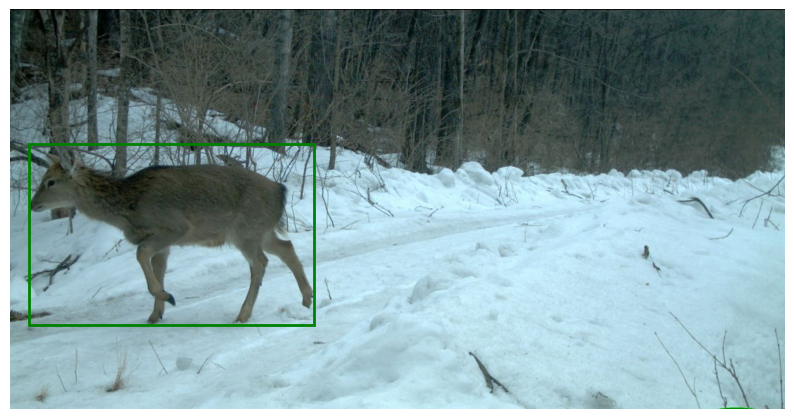

In [102]:
plt.figure(figsize=(10, 10))
plt.imshow(img)
show_mask(mask, plt.gca())
show_box(bbox.xyxy[0], plt.gca())
plt.axis('off')
plt.show()

In [71]:
from tqdm.auto import tqdm
import supervision as sv
import pycocotools
import json
import pycocotools.mask
import numpy as np
from ultralytics import YOLO
import albumentations as A
import os

test_folder = "test"
output_folder = "output_sam"  # Папка для сохранения результатов
os.makedirs(output_folder, exist_ok=True)
predictions = []
for file_name in tqdm(os.listdir(test_folder)):
    image_path = os.path.join(test_folder, file_name)
    image = read_img(image_path)
    predicts = predict_yolo_image(image)

    if predicts.xyxy is None:
        continue
    pred_classes = predicts.class_id.tolist()  # Классы объектов
    pred_boxes = predicts.xyxy.tolist()#instances.pred_boxes.tensor.tolist()  # Координаты bbox
    pred_scores = predicts.confidence.tolist()  # Скоринг предсказаний
        
    for i in range(len(pred_boxes)):
        mask , scores,_ = predict_sam(image,pred_boxes[i])
        if float(scores[0]) <= 0.5:
            continue
        rle = pycocotools.mask.encode(np.asfortranarray(mask.astype(np.uint8)[0]))
        predictions.append({
            "image_name": file_name,
            "category_id": 0,  # ID категории
            "bbox": pred_boxes[i],  # Координаты bounding box
            "score": float(scores[0]),  # Оценка уверенности
            "segmentation": {
                "size" : rle["size"],
                "counts" : str(rle["counts"])
            }  # Сегментация в формате RLE
        })


# Сохранение предсказаний в JSON
predictions_file = os.path.join(output_folder, "submission.json")
with open(predictions_file, "w") as f:
    json.dump(predictions, f, indent=4)

print(f"Обработка завершена. Результаты сохранены в папке: {output_folder}")

  0%|          | 0/9074 [00:00<?, ?it/s]


0: 544x1024 1 Animals, 19.8ms
Speed: 3.0ms preprocess, 19.8ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 1024)

0: 544x1024 1 Animals, 19.8ms
Speed: 3.2ms preprocess, 19.8ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 1024)

0: 544x1024 1 Animals, 19.8ms
Speed: 3.1ms preprocess, 19.8ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 1024)

0: 544x1024 1 Animals, 20.0ms
Speed: 3.2ms preprocess, 20.0ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 1024)

0: 544x1024 1 Animals, 19.8ms
Speed: 3.4ms preprocess, 19.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 1024)

0: 544x1024 1 Animals, 19.8ms
Speed: 3.1ms preprocess, 19.8ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 1024)

0: 544x1024 1 Animals, 19.9ms
Speed: 3.3ms preprocess, 19.9ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 1024)

0: 544x1024 1 Animals, 19.7ms
Speed: 3.0ms preprocess, 19.7ms inference, 1.4ms postprocess per i